In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import random
import itertools#final dest reached?

## Step 1: Setup and draw test network

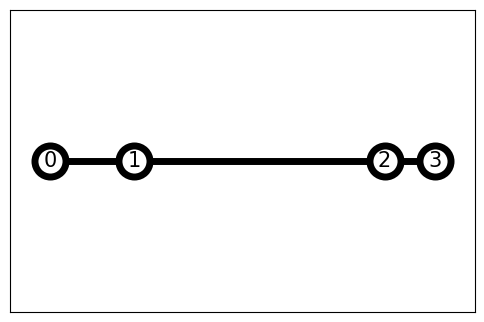

In [2]:
#setup grid
fig,ax=plt.subplots(dpi=100)

#create graph
G = nx.Graph()

#give in node list
nodes=[0,1,2,3]

#edge weights (dist in between)
dist=[50,150,30]


#make weighted edge list to add, then fill
edges=[]
for i in range(len(nodes)-1):
    edges.append((nodes[i],nodes[i+1],dist[i]))
    
#add weighted edges
G.add_weighted_edges_from(edges)

#explicitly set positions to match distances (just for visualization)
#first node is at (0,0)
pos_dict={0:(0,0)}
#other nodes are at summed dist to the right
for i in range(len(dist)):
    pos_dict[(i+1)]=(sum(dist[:(i+1)]),0)

#plotting options
options = {
    "font_size": 15,
    "node_size": 500,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 5,
    "width": 5,
}

#plot
nx.draw_networkx(G, pos=pos_dict, **options, labels={node: node for node in G.nodes()})

## Step 2: Deterimine which combinations can refuel each path

In [3]:
#this script is copied from: https://stackoverflow.com/questions/50634876/how-can-you-remove-superset-lists-from-a-list-of-lists-in-python
def get_minimal_subsets(sets):
    sets = sorted(map(set, sets), key=len)
    minimal_subsets = []
    for s in sets:
        if not any(minimal_subset.issubset(s) for minimal_subset in minimal_subsets):
            minimal_subsets.append(s)
    #added, converge to tuple
    tuples_inside = [tuple (k) for k in minimal_subsets]

    return tuples_inside

In [16]:
def first_stage_FRLM(G, r, OD):
    """ 
    Returns feasible charging station combinations for transport network G for routes in OD, considering travel range r, assuming that charging stations can be placed on any node of G. 
    Parameters
    ----------
    G : NetworkX graph
        must include all origins, desinations and any nodes where a refueling station may be placed.
    r : float
        range means of transport with full tank.
    OD: list 
        list of travel data within network G, travel data from A-B and from B-A should be summed up and entered as either one of them.
        example input:
        [(node_1, node_2, flow_12),(node_1, node_3, flow_13),(node_2, node_3, flow_23)]
        """
    #get data from graph in list format
    node_list = [i for i in G.nodes]
    edge_list = [i for i in G.edges]
    edge_list_w = []
    
    # Now also create weighted edge list in the format [(begin, start, weight),(..), etc.]
    for node in edge_list:
        edge_list_w.append((node[0],node[1],G.get_edge_data(node[0],node[1])['weight']))
    
    #collect paths to refuel and path lengths in dicts, first create empty dicts
    paths = {}
    path_lengths = {}
    
    #generate shortest paths for al origin destinations
    for path in OD:
        paths[(path[0],path[1])] = nx.dijkstra_path(G,path[0],path[1])
        # path_lengths[(path[0],path[1])] = nx.dijkstra_path_length(G,path[0],path[1],weight='weight')
    
    #make master dict with key q, with list of all feasible station combinations on q with r
    route_refuel_comb = {}
    for i,j in paths.items():
        h=[]
        # #functioning shortcut, now not nessecary: check if single station is enough
        # if r >= path_lengths[i]:
        #     h = [tuple (k) for k in str(j)]
        #     route_refuel_comb[i] = h
        # else:
        # create all possible station combinations on this path
        for L in range (0, len(j)+1):
                for k in itertools.combinations(j, (L+1)):
                    h.append(k)
        #now add to dict:
        route_refuel_comb[i] = h
        
    #now check feasibility
    #new master dict to store feasible combinations
    feasible_combinations = {}
    
    for route_key, route in route_refuel_comb.items():
        feasible_combinations[route_key] = []
        #store path for this route (on which round trip should be feasible) 
        path = paths[route_key]
        round_trip = path[:-1] + path[::-1]
        
        #now loop through all possible station combinations
        for combi in route:
            #start at origin
            current_pos = round_trip[0]
            #start with full range if refueling station at origin, otherwise half full
            if current_pos in combi:
                current_range = r
            else:
                current_range = r*0.5
            #simulate power levels during round trip
            #[1:] because first dest is second entry round trip list
            for sub_dest in round_trip[1:]:
#               #try to travel to new dest, first calculate dist to new destination
                dist = G.get_edge_data(current_pos,sub_dest)['weight']
                #only travel if dist is not too long
                if (current_range - dist) >= 0:
                    #if there is fuel station at destination: trip feasible
                    if (sub_dest in combi):
                        #final dest reached?
                        if (sub_dest == path[-1]):
                            feasible_combinations[route_key].append(combi)
                            break
                    #else: maybe feasible, double back route to check!
                    else:
                        if (sub_dest == path[0]):
                            feasible_combinations[route_key].append(combi)
                            break
                    #if not at final destination update range and pos
                    current_pos = sub_dest
                    current_range -= dist
                    #if there is a refueling station, refuel
                    if sub_dest in combi:
                        current_range = r
                    #check if at final dest
                else:
                    break
    
    #next: find and remove supersets
    for i,j in feasible_combinations.items():
        feasible_combinations[i] = get_minimal_subsets(feasible_combinations[i])
    
    #Reformat data: create two dicts one with b_qh values and one with g_qhk values
    #first create list of all possible combinations
    combinations=[]
    for i in feasible_combinations.values():
        combinations+=i
    
    #setup empty dict with keys to fill for dict 1
    dict_b = {'Route':[]}
    for j in combinations:
            dict_b[j] = []
    
    #first dict_
    for route_key, route in feasible_combinations.items():
        dict_b['Route'].append(route_key)
        for j in combinations:
            if j in route:
                dict_b[j].append(1)
            else:
                dict_b[j].append(0)
    
    #next dict to store g_qhk values
    dict_g={'q_h':[]}
    for i in node_list:
        dict_g[i] = []
    #now fill the lists
    for route_key, route in feasible_combinations.items():
        for combination in route:
            dict_g['q_h'].append((route_key,combination))
            for node in node_list:
                if node in combination:
                    if node in route_key:
                        dict_g[node].append(1)
                    else:
                        dict_g[node].append(2)
                else:
                    dict_g[node].append(0)


    return dict_b, dict_g

In [17]:
#import time to check performance
import time

%time dict_b, dict_g = first_stage_FRLM(G, 350, [(0,3,10),(0,2,5)])

CPU times: total: 0 ns
Wall time: 0 ns


In [18]:
df1 = pd.DataFrame.from_dict(dict_b)
df1.set_index('Route', inplace=True)
#matrix 1 as described in Kuby & Lim 2005
df1

,"(0, 3)","(1, 2)","(1, 3)","(1,)","(0, 2)"
Route,,,,,
"(0, 3)",1,1,1,0,0
"(0, 2)",0,0,0,1,1


In [19]:
df2 = pd.DataFrame.from_dict(dict_g)
df2.set_index('q_h', inplace=True)
#matrix 2 as described in Kuby & Lim 2005
# df2.iloc[:, 1:].sum(axis=1)
df2

,0,1,2,3
q_h,,,,
"((0, 3), (0, 3))",1,0,0,1
"((0, 3), (1, 2))",0,2,2,0
"((0, 3), (1, 3))",0,2,0,1
"((0, 2), (1,))",0,2,0,0
"((0, 2), (0, 2))",1,0,1,0


## Also test with larger graph
example taken:
https://networkx.org/documentation/stable/auto_examples/drawing/plot_tsp.html#sphx-glr-auto-examples-drawing-plot-tsp-py

The route of the traveller is: [0, 4, 19, 12, 2, 7, 10, 18, 5, 13, 6, 11, 3, 16, 17, 15, 14, 8, 9, 1, 0]


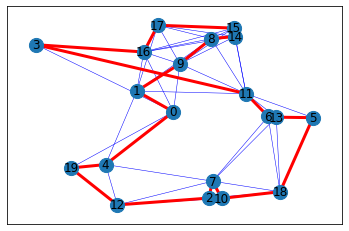

In [8]:
#test with larger network?
import networkx.algorithms.approximation as nx_app
import math

G2=nx.random_geometric_graph(20, radius=0.4, seed=3)
pos = nx.get_node_attributes(G2, "pos")

# Depot should be at (0,0)
pos[0] = (0.5, 0.5)

H = G2.copy()


# Calculating the distances between the nodes as edge's weight.
for i in range(len(pos)):
    for j in range(i + 1, len(pos)):
        dist = math.hypot(pos[i][0] - pos[j][0], pos[i][1] - pos[j][1])
        dist = dist
        G2.add_edge(i, j, weight=dist)
        # print(dist)

cycle = nx_app.christofides(G2, weight="weight")
edge_list = list(nx.utils.pairwise(cycle))

# Draw closest edges on each node only
nx.draw_networkx_edges(H, pos, edge_color="blue", width=0.5)

# Draw the route
nx.draw_networkx(
    G2,
    pos,
    with_labels=True,
    edgelist=edge_list,
    edge_color="red",
    node_size=200,
    width=3,
)

print("The route of the traveller is:", cycle)
plt.show()

In [9]:
%time dict_df1, dict_df2 = first_stage_FRLM(G2, 1, [(19,5,10),(4,8,5)])

CPU times: total: 0 ns
Wall time: 0 ns


In [10]:
#oops complete graph chosen, bad example..

## Step 3: Optimize

Basic steps:
1. Import the linear solver wrapper,
2. declare the LP solver,
3. define the variables,
4. define the constraints,
5. define the objective,
6. call the LP solver; and
7. display the solution

Based on:
- https://towardsdatascience.com/introduction-to-linear-programming-in-python-9261e7eb44b
- https://developers.google.com/optimization/mip/mip_var_array
- https://developers.google.com/optimization/lp/lp_example

In [15]:
import pulp


In [11]:
#manual try
def second_stage_FRLM(G, n, c, df_qh, df_hk, OD):
    """ This program optimally sites n charging stations for vehicles with a range r, based on two DataFrames that are generated by the first_stage_FRLM function.
        Parameters
        ----------
        G : NetworkX graph
            must include all origins, desinations and any nodes where a refueling station may be placed.
        n : int
            #stations to locate on any node of G.
        c : float
            max average flow a charging station can cope with.
        df_qh : pd.DataFrame()
            DataFrame with a row for each route (q) and a column for each existing charging station combination (h). b_qh = 1 combination h can support trips on path h, 0 otherwise.
            df_qh is generated by the first_stage_FRLM function.
        df_kh : pd.DataFrame()
            DataFrame with a row for each charging station combination (h), and a column for each unique facility (k). a_qh = 1 if combination k is in combination h, 0 otherwise.   
            df_kh is generated by the first_stage_FRLM function.
        OD: list 
        list of travel data within network G, travel data from A-B and from B-A should be summed up and entered as either one of them.
        example input:
        [(node_1, node_2, flow_12),(node_1, node_3, flow_13),(node_2, node_3, flow_23)]
        
        """
    #step 1: create empty list with placed fuel stations
    stations = []
    
    #step 2:

In [12]:
## 1
from ortools.linear_solver import pywraplp

def second_stage_FRLM_opt(G, n, c, df_qh, df_hk):
    """ This program optimally sites n charging stations for vehicles with a range r, based on two DataFrames that are generated by the first_stage_FRLM function.
        Parameters
        ----------
        G : NetworkX graph
            must include all origins, desinations and any nodes where a refueling station may be placed.
        n : int
            #stations to locate on any node of G.
        c : float
            max average flow a charging station can cope with.
        df_qh : pd.DataFrame()
            DataFrame with a row for each route (q) and a column for each existing charging station combination (h). b_qh = 1 combination h can support trips on path h, 0 otherwise.
            df_qh is generated by the first_stage_FRLM function.
        df_kh : pd.DataFrame()
            DataFrame with a row for each charging station combination (h), and a column for each unique facility (k). a_qh = 1 if combination k is in combination h, 0 otherwise.   
            df_kh is generated by the first_stage_FRLM function.
        OD: list 
        list of travel data within network G, travel data from A-B and from B-A should be summed up and entered as either one of them.
        example input:
        [(node_1, node_2, flow_12),(node_1, node_3, flow_13),(node_2, node_3, flow_23)]
        
        """
    ## 2 Create a solver using the GLOP backend
    solver = pywraplp.Solver('Maximize captured flow', pywraplp.Solver.GLOP_LINEAR_PROGRAMMING)
    
    ## 3 define the decision variables
    
    #create decision variables, decision: realize charging station combination or not
    x = {}
    #loop over all combinations
    for j in range(len(df1.columns[1:])):
        #create decision variable for each combination, build (1) or not (0).
        x[j] = solver.IntVar(0, 1, 'x[%i]' % j)
    print('Number of variables =', solver.NumVariables())
    
    ## 4 define constraints
    #total amount of charging stations may not exceed n
    x = 
    solver.Add(
    print('Number of constraints =', solver.NumConstraints())

    
    



SyntaxError: invalid syntax (2127104385.py, line 41)

In [ ]:
second_stage_FRLM(G, 1, 10, df1, df2)